# **Exploratory Data Analysis**

Here, we analyze the Reviews.csv file, gaining an understanding of the reviews dataset and its quality.

### Import Libraries & Data

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
df = pd.read_csv('../data/Reviews.csv')

### Checks

In [51]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None


In [52]:
print(df.describe())

                  Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817                 2.22881   
std    164098.679298              7.636513                 8.28974   
min         1.000000              0.000000                 0.00000   
25%    142114.250000              0.000000                 0.00000   
50%    284227.500000              0.000000                 1.00000   
75%    426340.750000              2.000000                 2.00000   
max    568454.000000            866.000000               923.00000   

               Score          Time  
count  568454.000000  5.684540e+05  
mean        4.183199  1.296257e+09  
std         1.310436  4.804331e+07  
min         1.000000  9.393408e+08  
25%         4.000000  1.271290e+09  
50%         5.000000  1.311120e+09  
75%         5.000000  1.332720e+09  
max         5.000000  1.351210e+09  


In [53]:
print("Dataframe Shape:")
print(df.shape)

Dataframe Shape:
(568454, 10)


In [54]:
print("Dataframe Columns:")
print(df.columns)

Dataframe Columns:
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [55]:
print("Dataframe Head:")
print(df.head())

Dataframe Head:
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality 

In [56]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


Very minimal missing information, we can drop all rows with missing values later on with no concerns.

In [57]:
print("Duplicate Values:")
print(df.duplicated().sum())

Duplicate Values:
0


In [58]:
print("How Many Products are there in the dataset:")
print(len(df["ProductId"].unique()))
print()

How Many Products are there in the dataset:
74258



### Understanding Our Features

count    568454.000000
mean        436.222083
std         445.339741
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
Name: review_length, dtype: float64


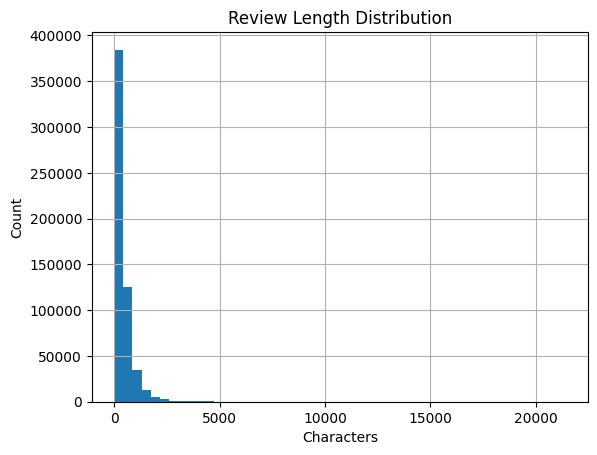

In [59]:
# Analyze review length

df["review_length"] = df["Text"].astype(str).apply(len)
print(df["review_length"].describe())

df["review_length"].hist(bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()

<Axes: title={'center': 'Distribution of Ratings (1-5)'}, xlabel='Score'>

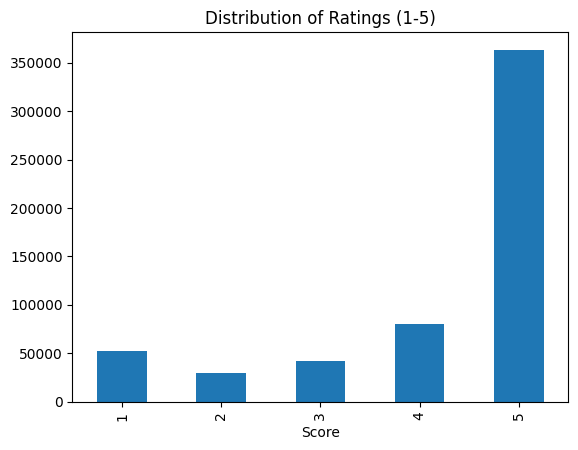

In [60]:
# Analyze score distribution
df["Score"].value_counts().sort_index().plot(
    kind="bar", title="Distribution of Ratings (1-5)"
)

Text(0, 0.5, 'Count')

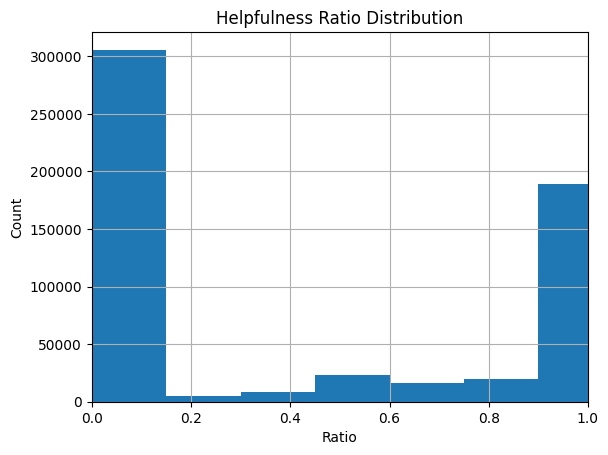

In [61]:
# Analyze review helpfulness
df["helpfulness_ratio"] = df["HelpfulnessNumerator"] / df["HelpfulnessDenominator"].replace(0, 1)
df["helpfulness_ratio"].hist(bins=20)
plt.title("Helpfulness Ratio Distribution")
plt.xlim(0, 1)
plt.xlabel("Ratio")
plt.ylabel("Count")

In [62]:
# Top Bigrams in Positive Reviews & Negative Reviews

# Clean the review text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)  # remove URLs
    text = re.sub(r"<.*?>", " ", text)                    # remove HTML tags
    text = re.sub(r"[^a-z\s]", " ", text)                 # keep only letters
    text = re.sub(r"\s+", " ", text).strip()              # remove extra spaces
    return text
df["clean_text"] = df["Text"].apply(clean_text)

# Positive reviews (>=4 stars)
pos_reviews = df[df["Score"] >= 4]["clean_text"]
pos_vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(2, 2),
    max_features=20
)
pos_vec = pos_vectorizer.fit_transform(pos_reviews)
top_pos = pos_vectorizer.get_feature_names_out()

# Negative reviews (<=2 stars)
neg_reviews = df[df["Score"] <= 2]["clean_text"]
neg_vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(2, 2),
    max_features=20
)
neg_vec = neg_vectorizer.fit_transform(neg_reviews)
top_neg = neg_vectorizer.get_feature_names_out()

# Keep only opinion-bearing bigrams (removes bigrams like (dog, food))
nlp = spacy.load("en_core_web_sm")
def keep_opinion_bigrams(bigrams):
    opinion_bigrams = []
    for phrase in bigrams:
        doc = nlp(phrase)
        if any(tok.pos_ == "ADJ" for tok in doc) or any(tok.pos_ == "VERB" for tok in doc):
            opinion_bigrams.append(phrase)
    return opinion_bigrams
top_pos_bigrams = keep_opinion_bigrams(top_pos)
top_neg_bigrams = keep_opinion_bigrams(top_neg)

# Output the top bigrams
print("Top positive bigrams:", top_pos_bigrams[:20])
print()
print("Top negative bigrams:", top_neg_bigrams[:20])

Top positive bigrams: ['gluten free', 'great product', 'highly recommend', 'really good', 'subscribe save', 'taste great', 'taste like', 'tastes great', 've tried', 'year old']

Top negative bigrams: ['don know', 'don think', 'gluten free', 'taste good', 'taste like', 'tasted like', 've tried', 'waste money']
